In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib notebook
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [2]:
demo = pd.read_csv("data/demographic.csv")
# demographic.csv columns have space as a first character.. remove it!
demo.columns = [col.replace(' ', '') for col in demo.columns]
erp_data = pd.read_csv("data/ERPdata.csv")

,subject,condition,FC4,C4,CP4,FC3,C3,CP3,group,gender,age,education
0,1,Button tone,-1.754095,-1.411906,-1.713631,-3.623855,-2.864079,-2.796495,Control,M,44,16.0
1,1,Control press,-1.927416,-1.311639,-2.030604,-2.376894,-3.119468,-2.909333,Control,M,44,16.0
2,2,Button tone,-0.676889,-0.232035,-0.514371,-1.231047,-1.141242,-0.607670,Control,M,39,17.0
3,2,Control press,0.391040,0.856605,0.579452,0.733641,0.824525,0.992221,Control,M,39,17.0
4,3,Button tone,-4.243524,-3.060327,-1.592617,-4.126250,-1.919484,-0.433224,Control,M,53,18.0
5,3,Control press,0.759739,3.158410,3.708572,1.348654,1.965423,3.224192,Control,M,53,18.0
6,4,Button tone,-1.434151,-1.251261,-0.758620,-3.406878,-3.206953,-2.289590,Control,M,52,15.0
7,4,Control press,-1.090816,-1.975662,-1.294551,-1.532150,-1.402029,-1.079045,Control,M,52,15.0
8,5,Button tone,-0.823886,-1.089808,-0.746429,-1.380179,-1.307772,-0.840295,Control,M,41,16.0
9,5,Control press,-3.031956,-2.811327,-1.682536,-3.444261,-2.236882,-1.047005,Control,M,41,16.0


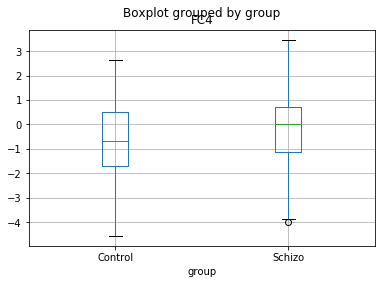

In [3]:
#####################
### LRP amplitude ###
#####################


# Electrodes
elec_right = ['FC4', 'C4', 'CP4']
elec_left = ['FC3', 'C3', 'CP3']
electrodes_lrp = elec_right + elec_left

# Substract baseline
BL = erp_data[(erp_data.time_ms >= -600) & (erp_data.time_ms <= -500)].groupby(['subject', 'condition']).mean()
RPamps = erp_data[(erp_data.time_ms >= -100) & (erp_data.time_ms <= 0)].groupby(['subject', 'condition']).mean()
RPamps = RPamps[electrodes_lrp] - BL[electrodes_lrp]

# Drop playback (won't need it here)
RPamps = RPamps.drop(index=2, level=1)
RPamps = RPamps.reset_index()

# Give proper names to group and condition values
RPamps_demo = RPamps.merge(demo, on='subject')
RPamps_demo.group.replace(to_replace={0: 'Control', 1: 'Schizo'}, inplace=True)
RPamps_demo.condition.replace(to_replace={1: 'Button tone', 3: 'Control press'}, inplace=True)

# Display for testing
display(RPamps_demo[:10])

# Boxplot
RPamps_demo.boxplot('FC4', by='group', figsize=(6, 4))

In [4]:
#convert electrode columns to rows with labels:
RPamps_demo = pd.melt(RPamps_demo, id_vars=['subject', 'group', 'condition'], value_vars=['FC4', 'C4', 'CP4','FC3', 'C3', 'CP3'], var_name='electrode', value_name='RP')
RPamps_demo.head(10)

,subject,group,condition,electrode,RP
0,1,Control,Button tone,FC4,-1.754095
1,1,Control,Control press,FC4,-1.927416
2,2,Control,Button tone,FC4,-0.676889
3,2,Control,Control press,FC4,0.391040
4,3,Control,Button tone,FC4,-4.243524
5,3,Control,Control press,FC4,0.759739
6,4,Control,Button tone,FC4,-1.434151
7,4,Control,Control press,FC4,-1.090816
8,5,Control,Button tone,FC4,-0.823886
9,5,Control,Control press,FC4,-3.031956


In [5]:
#Add the hemisphere column
RPamps_demo['hemisphere'] = RPamps_demo['electrode']
RPamps_demo['hemisphere'] = RPamps_demo['hemisphere'].apply(lambda x: 'left' if '3' in x else 'right')

In [6]:
#Remove the numbers from the electrodes
RPamps_demo['electrode'] = RPamps_demo['electrode'].str[:-1]

In [7]:
RPamps_demo.head()

,subject,group,condition,electrode,RP,hemisphere
0,1,Control,Button tone,FC,-1.754095,right
1,1,Control,Control press,FC,-1.927416,right
2,2,Control,Button tone,FC,-0.676889,right
3,2,Control,Control press,FC,0.391040,right
4,3,Control,Button tone,FC,-4.243524,right


In [8]:
N1amps = erp_data[(erp_data.time_ms >= 80) & (erp_data.time_ms <= 100)].groupby(['subject', 'condition']).mean()
N1amps.loc[(slice(None),1), ['Fz', 'FCz', 'Cz']] = N1amps.loc[(slice(None),1), ['Fz', 'FCz', 'Cz']] - N1amps.loc[(slice(None),3), ['Fz', 'FCz', 'Cz']].values
N1amps = N1amps.drop(index=3, level=1)

In [9]:
N1amps=N1amps.reset_index()
N1amps = pd.melt(N1amps, id_vars=['subject', 'condition'], value_vars=['Fz', 'FCz', 'Cz'])
N1amps.condition.replace(to_replace={1: 'Button tone', 2: 'Playback'}, inplace=True)
N1amps.head()

,subject,condition,variable,value
0,1,Button tone,Fz,-4.937118
1,1,Playback,Fz,-8.308424
2,2,Button tone,Fz,-3.515848
3,2,Playback,Fz,-5.300647
4,3,Button tone,Fz,0.334000


In [10]:
N1amps = N1amps.merge(demo, on='subject')
N1amps.group.replace(to_replace={0: 'Control', 1: 'Schizo'}, inplace=True)
N1amps.head()

,subject,condition,variable,value,group,gender,age,education
0,1,Button tone,Fz,-4.937118,Control,M,44,16.0
1,1,Playback,Fz,-8.308424,Control,M,44,16.0
2,1,Button tone,FCz,-4.861151,Control,M,44,16.0
3,1,Playback,FCz,-8.990923,Control,M,44,16.0
4,1,Button tone,Cz,-4.567639,Control,M,44,16.0


In [11]:
###LRP amplitude
N1df = N1amps[(N1amps['condition'] == 'Button tone') & (N1amps['variable'] == 'FCz')].merge(N1amps[(N1amps['condition'] == 'Playback') & (N1amps['variable'] == 'FCz')], on='subject')

In [12]:
N1df['N1supp'] = N1df['value_x']-N1df['value_y']
N1df

,subject,condition_x,variable_x,value_x,group_x,gender_x,age_x,education_x,condition_y,variable_y,value_y,group_y,gender_y,age_y,education_y,N1supp
0,1,Button tone,FCz,-4.861151,Control,M,44,16.0,Playback,FCz,-8.990923,Control,M,44,16.0,4.129772
1,2,Button tone,FCz,-3.480376,Control,M,39,17.0,Playback,FCz,-5.608960,Control,M,39,17.0,2.128584
2,3,Button tone,FCz,0.434816,Control,M,53,18.0,Playback,FCz,-6.284744,Control,M,53,18.0,6.719560
3,4,Button tone,FCz,-3.267771,Control,M,52,15.0,Playback,FCz,-7.032685,Control,M,52,15.0,3.764914
4,5,Button tone,FCz,-4.599510,Control,M,41,16.0,Playback,FCz,-6.166350,Control,M,41,16.0,1.566840
5,6,Button tone,FCz,-4.730307,Control,F,47,18.0,Playback,FCz,-6.407965,Control,F,47,18.0,1.677658
6,7,Button tone,FCz,-6.991224,Control,F,61,16.0,Playback,FCz,-7.986653,Control,F,61,16.0,0.995429
7,8,Button tone,FCz,-1.414054,Control,M,45,16.0,Playback,FCz,-4.360373,Control,M,45,16.0,2.946319
8,9,Button tone,FCz,-0.332331,Control,M,25,17.0,Playback,FCz,-2.051355,Control,M,25,17.0,1.719024
9,10,Button tone,FCz,-3.847227,Control,M,53,19.0,Playback,FCz,-5.241011,Control,M,53,19.0,1.393784


In [13]:
LRPdf = RPamps_demo[(RPamps_demo['condition'] == 'Button tone') & (RPamps_demo['electrode'] == 'C') & (RPamps_demo['hemisphere'] == 'left')].merge(RPamps_demo[(RPamps_demo['condition'] == 'Button tone') & (RPamps_demo['electrode'] == 'C') & (RPamps_demo['hemisphere'] == 'right')], on='subject')
LRPdf['LRP'] = LRPdf['RP_x']-LRPdf['RP_y']
LRPdf

,subject,group_x,condition_x,electrode_x,RP_x,hemisphere_x,group_y,condition_y,electrode_y,RP_y,hemisphere_y,LRP
0,1,Control,Button tone,C,-2.864079,left,Control,Button tone,C,-1.411906,right,-1.452172
1,2,Control,Button tone,C,-1.141242,left,Control,Button tone,C,-0.232035,right,-0.909208
2,3,Control,Button tone,C,-1.919484,left,Control,Button tone,C,-3.060327,right,1.140843
3,4,Control,Button tone,C,-3.206953,left,Control,Button tone,C,-1.251261,right,-1.955692
4,5,Control,Button tone,C,-1.307772,left,Control,Button tone,C,-1.089808,right,-0.217964
5,6,Control,Button tone,C,2.491831,left,Control,Button tone,C,0.675850,right,1.815982
6,7,Control,Button tone,C,-2.211304,left,Control,Button tone,C,-3.031563,right,0.820259
7,8,Control,Button tone,C,-0.884539,left,Control,Button tone,C,-0.598065,right,-0.286474
8,9,Control,Button tone,C,0.009813,left,Control,Button tone,C,-0.306149,right,0.315962
9,10,Control,Button tone,C,-2.632722,left,Control,Button tone,C,-4.739690,right,2.106968


In [14]:
N1LRPdf = N1df.merge(LRPdf, on='subject')
N1LRPdf = N1LRPdf[['subject', 'LRP', 'N1supp', 'group_x_x']]
N1LRPdf['group_x_x'] = N1LRPdf['group_x_x'].apply(lambda x: 0 if x=='Control' else 1)
N1LRPdf = N1LRPdf.rename(index=str, columns={'group_x_x': 'Group'})
N1LRPdf.head()

,subject,LRP,N1supp,Group
0,1,-1.452172,4.129772,0
1,2,-0.909208,2.128584,0
2,3,1.140843,6.719560,0
3,4,-1.955692,3.764914,0
4,5,-0.217964,1.566840,0


In [15]:
X = N1LRPdf[['LRP', 'N1supp']]
y = N1LRPdf['Group']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
clf = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)
clf.fit(X_train,y_train)
print(clf.score(X_test, y_test))

0.6470588235294118


In [18]:
svm = LinearSVC(random_state=0)
svm.fit(X_train,y_train)
print(svm.score(X_test, y_test))

0.5882352941176471


C:\Users\miq\Miniconda3\envs\Py3_ICNS\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
